# Fitting a resonator measured in reflection
- To setup, download https://github.com/sebastianprobst/resonator_tools
- Run `python setup.py install`
- Fano fits the `Q_total`

In [2]:
%matplotlib notebook
from typing import Dict, List
import itertools


from resonator_tools import circuit
import numpy as np
import pandas as pd
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, FloatSlider, RadioButtons
import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.style.use('support-files/qubit.mplstyle')
from scipy.optimize import curve_fit
GHz = 10**9
MHz = 10**6

# Playground

In [2]:
def resonator_kernel(freq_list: List[float], system_parameters: Dict):
    try:
        return (
            1 - (
                system_parameters["Q_load"]
                / system_parameters["Q_coupling"]
                * np.exp(1j * system_parameters["phi"])
            ) / (
                1
                + 1j
                * 2
                * system_parameters["Q_load"]
                * (freq_list / system_parameters["f_res"] - 1)
            )
        ) * (
            system_parameters["att"]
            * np.exp(
                -1j
                * 2
                * np.pi
                * freq_list
                * system_parameters["tau"])
        )
    except KeyError as err:
        raise RuntimeError(f"Missing dictionary entry: {err}")


def resonator_kernel_transmission(freq_list: List[float], system_parameters: Dict):
    try:
        return (
            system_parameters["Q_load"]
            / system_parameters["Q_coupling"]
            * np.exp(1j * system_parameters["phi"])
        ) / (
            1
            + 1j
            * 2
            * system_parameters["Q_load"]
            * (freq_list / system_parameters["f_res"] - 1)
        ) * (
            system_parameters["att"]
            * np.exp(
                -1j
                * 2
                * np.pi
                * freq_list
                * system_parameters["tau"])
        )
    except KeyError as err:
        raise RuntimeError(f"Missing dictionary entry: {err}")


def generate_freq_list(f_central: float, f_sd: float, size: int) -> List[float]:
    """Gaussian distribution"""
    return np.sort(
        np.random.normal(
            loc=f_central,
            scale=f_sd,
            size=size))


def generate_size_list(f_central: float, freq_list: List[float]) -> List[int]:
    """Resonance frequency point given bigger size"""
    f_res_idx = len(
        list(
            itertools.takewhile(
                lambda x: x < f_central, freq_list)))
    size_list = [1] * len(freq_list)
    size_list[f_res_idx] = 20

    return size_list

In [3]:
system_parameters = {
    "f_res": 5 * GHz,
    "Q_load": 100,
    "Q_coupling": 10,
    "phi": 0,
    "att": 1,
    "tau": 0
}
simulation_parameters = {
    "N": 1000,
    "spread_dev": GHz / 5
}

# Evaluate once
freq_list = generate_freq_list(
    system_parameters["f_res"],
    simulation_parameters["spread_dev"],
    simulation_parameters["N"])

size_list = generate_size_list(system_parameters["f_res"], freq_list)

### Notch

<IPython.core.display.Javascript object>


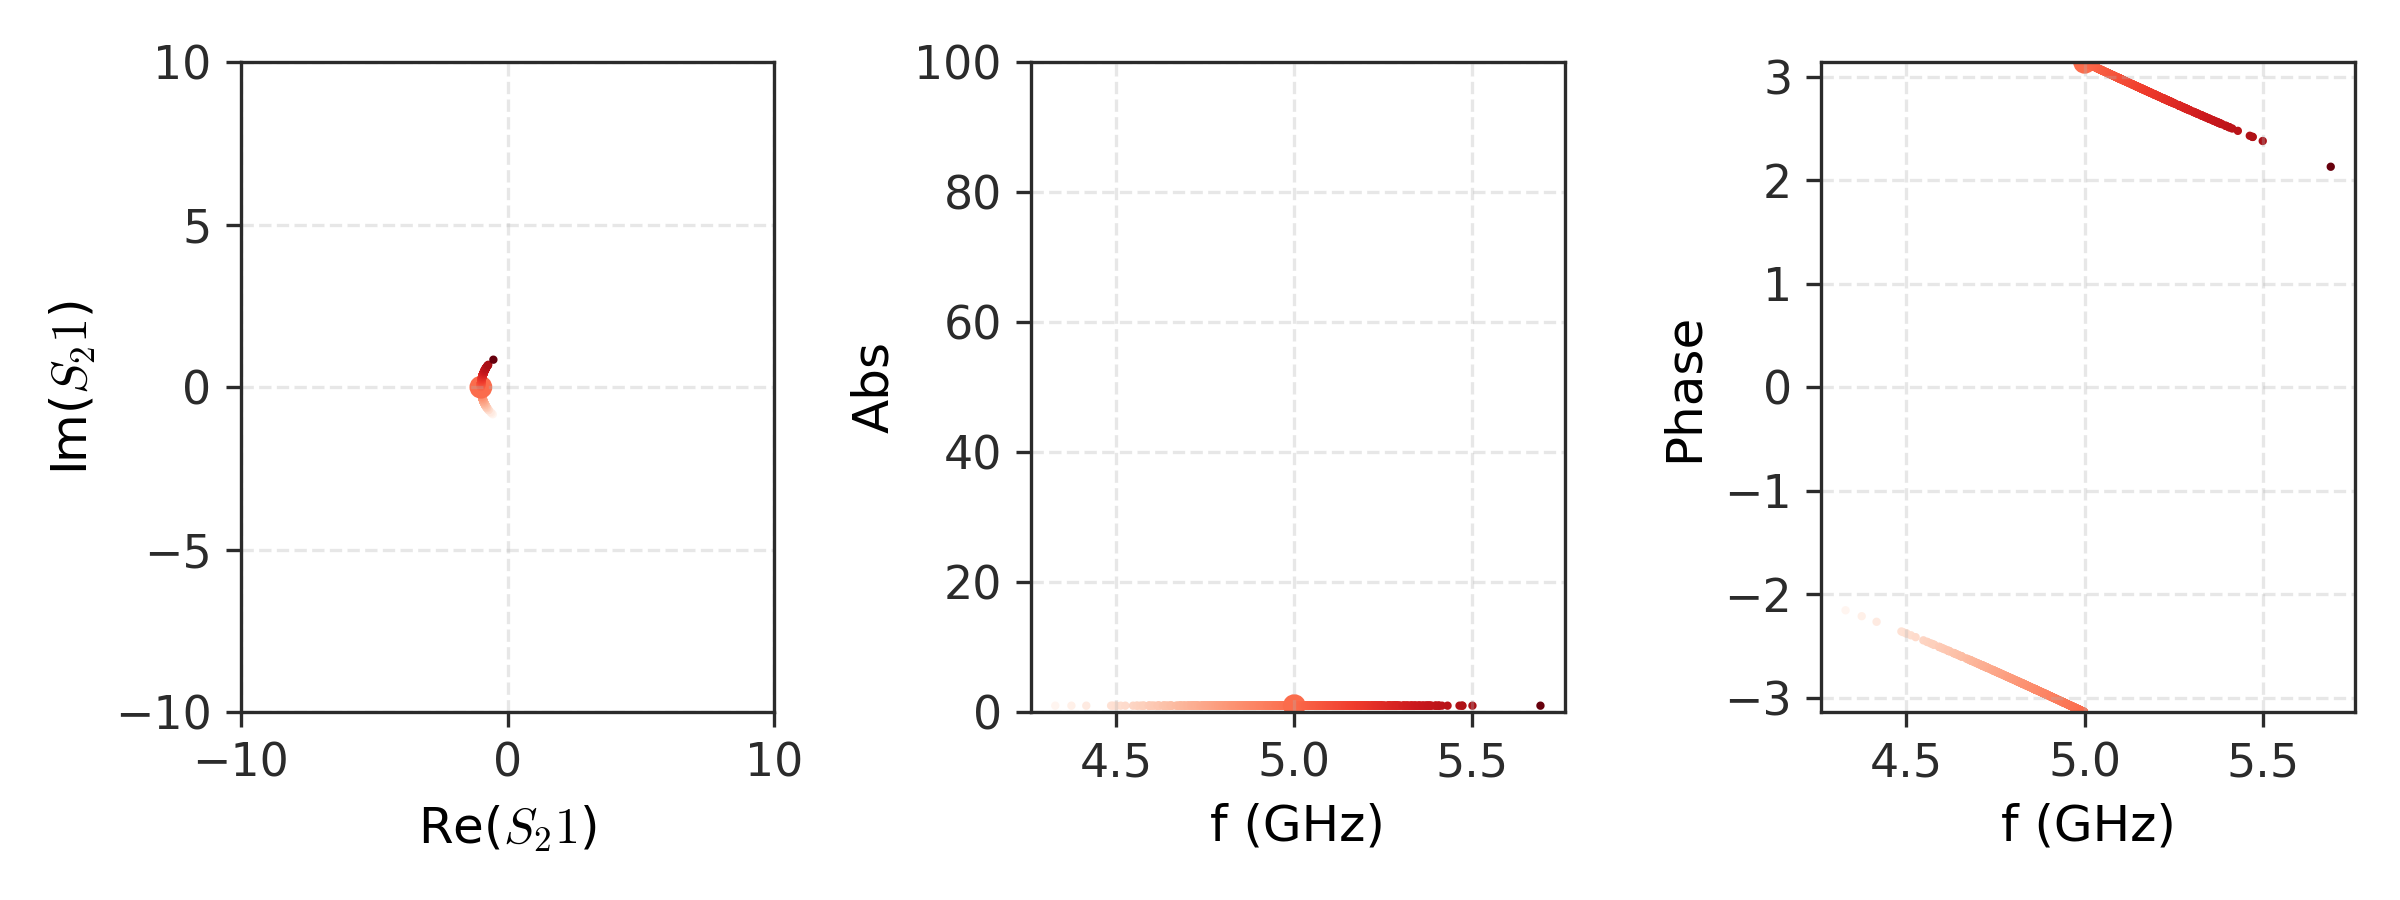

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].set_xlabel("Re($S_21$)", fontsize=12)
ax[0].set_ylabel("Im($S_21$)", fontsize=12)
ax[1].set_xlabel("f (GHz)", fontsize=12)
ax[1].set_ylabel("Abs", fontsize=12)
ax[2].set_xlabel("f (GHz)", fontsize=12)
ax[2].set_ylabel("Phase", fontsize=12)

ax[0].set_xlim([-10, 10])
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([0, 100])
ax[2].set_ylim([-np.pi, np.pi])

# First plot
reflection = resonator_kernel(freq_list, system_parameters)
sc = ax[0].scatter(
        np.real(reflection),
        np.imag(reflection),
        c=freq_list,
        s=size_list,
        cmap="Reds"
    )
amp = ax[1].scatter(
    freq_list / GHz,
    np.abs(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
phase = ax[2].scatter(
    freq_list / GHz,
    np.angle(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
plt.tight_layout()

# Update function - must be here to refference variables from above
def resonator_plot(Q_load: float, Q_coupling: float, phi: float, att: float, tau: float):
    system_parameters.update(
        {
            "Q_load": Q_load,
            "Q_coupling": Q_coupling,
            "phi": phi,
            "att": att,
            "tau": tau / 10**10
        })
    print(system_parameters)

    reflection = resonator_kernel(freq_list, system_parameters)
    sc.set_offsets(np.c_[np.real(reflection), np.imag(reflection)])
    amp.set_offsets(np.c_[freq_list / GHz, np.abs(reflection)])
    phase.set_offsets(np.c_[freq_list / GHz, np.angle(reflection)])
    
# Widgets
# color_buttons = RadioButtons(options=['blue', 'green', 'red'])    
Q_load_widget = widgets.FloatLogSlider(
#     min=100, max=10000, step=100, 
    base=10, min=0, max=3,value=np.log10(system_parameters["Q_load"]),
    description="Q_load",
    layout=widgets.Layout(width='800px', height='100px'))
Q_coupling_widget = widgets.FloatLogSlider(
    base=10, min=0, max=2.5, value=np.log10(system_parameters["Q_coupling"]),
#     min=100, max=10000, step=100, value=system_parameters["Q_coupling"]
    description="Q_coupling",
    layout=widgets.Layout(width='800px', height='100px'))
phi_widget = FloatSlider(
    min=0, max=2 * np.pi,
    description="phi", value=system_parameters["phi"])
att_widget = FloatSlider(
    min=0, max=10,
    description="Attenuation", value=system_parameters["att"],
    layout=widgets.Layout(width='800px', height='100px'))
tau_widget = FloatSlider(
    min=0, max=100, step=1,
    description="Tau", value=system_parameters["tau"],
    layout=widgets.Layout(width='800px', height='100px'))

quality_box = widgets.HBox([Q_load_widget, Q_coupling_widget])
external_box = widgets.HBox([att_widget, tau_widget])
other_box = widgets.HBox([phi_widget])
ui = widgets.VBox([quality_box, external_box, other_box])

In [5]:
out = widgets.interactive_output(
    resonator_plot, 
    {"Q_load":Q_load_widget, 
    "Q_coupling": Q_coupling_widget, 
    "phi":phi_widget,
    "att": att_widget,
     "tau": tau_widget
    }
    )

display(ui, out)

Output()

### Transmission

<IPython.core.display.Javascript object>


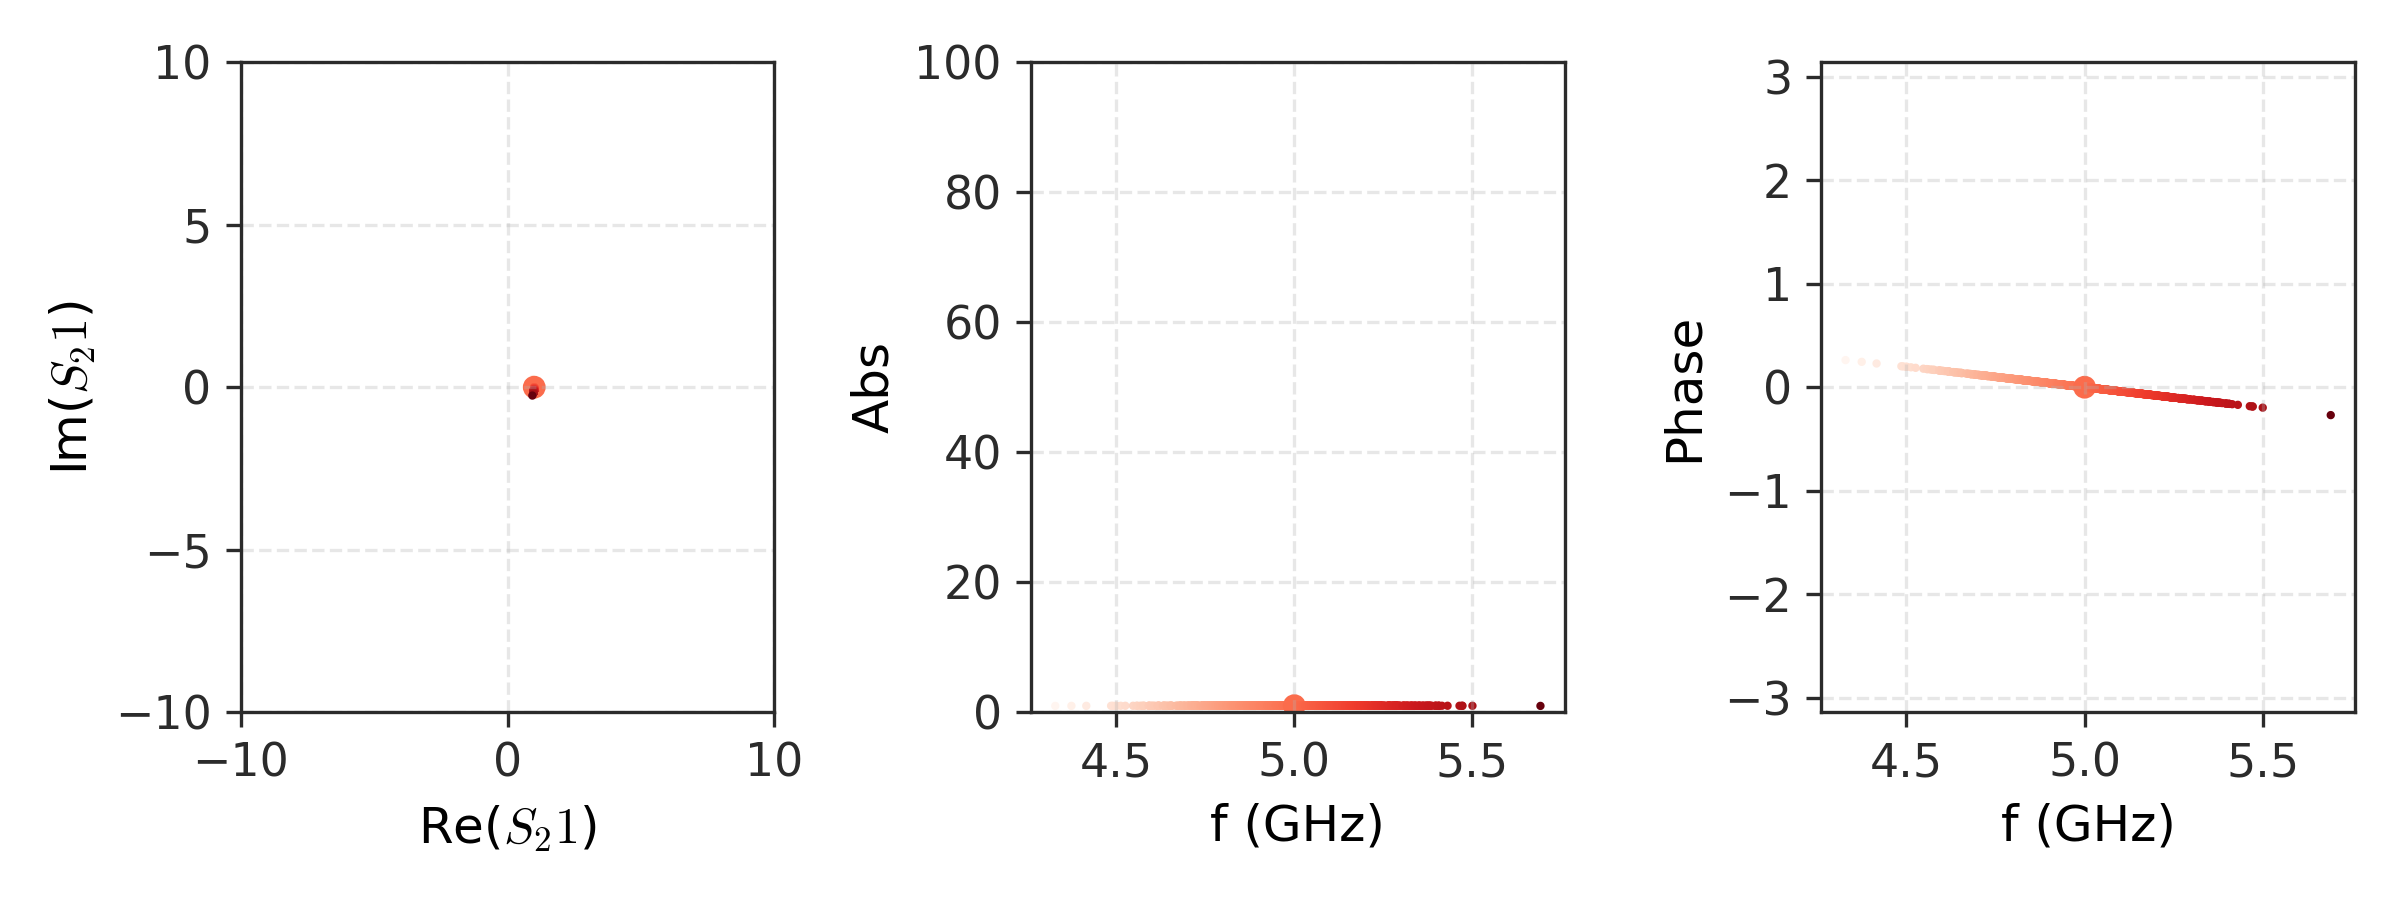

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].set_xlabel("Re($S_21$)", fontsize=12)
ax[0].set_ylabel("Im($S_21$)", fontsize=12)
ax[1].set_xlabel("f (GHz)", fontsize=12)
ax[1].set_ylabel("Abs", fontsize=12)
ax[2].set_xlabel("f (GHz)", fontsize=12)
ax[2].set_ylabel("Phase", fontsize=12)

ax[0].set_xlim([-10, 10])
ax[0].set_ylim([-10, 10])
ax[1].set_ylim([0, 100])
ax[2].set_ylim([-np.pi, np.pi])

# First plot
reflection = resonator_kernel_transmission(freq_list, system_parameters)
sc = ax[0].scatter(
        np.real(reflection),
        np.imag(reflection),
        c=freq_list,
        s=size_list,
        cmap="Reds"
    )
amp = ax[1].scatter(
    freq_list / GHz,
    np.abs(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
phase = ax[2].scatter(
    freq_list / GHz,
    np.angle(reflection),
    c=freq_list,
        s=size_list,
        cmap="Reds"
    )
plt.tight_layout()

# Update function - must be here to refference variables from above
def resonator_plot(Q_load: float, Q_coupling: float, phi: float, att: float, tau: float):
    system_parameters.update(
        {
            "Q_load": Q_load,
            "Q_coupling": Q_coupling,
            "phi": phi,
            "att": att,
            "tau": tau / 10**10
        })
    print(system_parameters)

    reflection = resonator_kernel_transmission(freq_list, system_parameters)
    sc.set_offsets(np.c_[np.real(reflection), np.imag(reflection)])
    amp.set_offsets(np.c_[freq_list / GHz, np.abs(reflection)])
    phase.set_offsets(np.c_[freq_list / GHz, np.angle(reflection)])
    
# Widgets
# color_buttons = RadioButtons(options=['blue', 'green', 'red'])    
Q_load_widget = widgets.FloatLogSlider(
#     min=100, max=10000, step=100, 
    base=10, min=0, max=3,value=np.log10(system_parameters["Q_load"]),
    description="Q_load",
    layout=widgets.Layout(width='800px', height='100px'))
Q_coupling_widget = widgets.FloatLogSlider(
    base=10, min=0, max=2.5, value=np.log10(system_parameters["Q_coupling"]),
#     min=100, max=10000, step=100, value=system_parameters["Q_coupling"]
    description="Q_coupling",
    layout=widgets.Layout(width='800px', height='100px'))
phi_widget = FloatSlider(
    min=0, max=2 * np.pi,
    description="phi", value=system_parameters["phi"])
att_widget = FloatSlider(
    min=0, max=10,
    description="Attenuation", value=system_parameters["att"],
    layout=widgets.Layout(width='800px', height='100px'))
tau_widget = FloatSlider(
    min=0, max=100, step=1,
    description="Tau", value=system_parameters["tau"],
    layout=widgets.Layout(width='800px', height='100px'))

quality_box = widgets.HBox([Q_load_widget, Q_coupling_widget])
external_box = widgets.HBox([att_widget, tau_widget])
other_box = widgets.HBox([phi_widget])
ui = widgets.VBox([quality_box, external_box, other_box])

In [7]:
out = widgets.interactive_output(
    resonator_plot, 
    {"Q_load":Q_load_widget, 
    "Q_coupling": Q_coupling_widget, 
    "phi":phi_widget,
    "att": att_widget,
     "tau": tau_widget
    }
    )

display(ui, out)

Output()

# Experimental Fitting - run once
##### Fano fit
\begin{equation}
F(\omega) = A + B \frac{\left[q + 2(\omega - \omega_0)/\Gamma)\right]^2}{1 + \left[2(\omega - \omega_0)/\Gamma)\right]^2}
\end{equation}

and the $Q$ factor is then:

\begin{equation}
Q_l = \frac{\omega_0}{\Gamma}
\end{equation}

##### Circle fit
\begin{equation}
S_{21}(f)=ae^{i\alpha}e^{-i2\pi{f}\tau}\left[1 - \frac{(Q/\left|Q_e\right|)e^{i\varphi}}{1 + i2Q(f/f_r - 1)}\right]
\end{equation}

is fitted in order to derive:

\begin{equation}
 \frac{1}{Q_{l}} = \frac{1}{Q_{i}} + \Re\left[\frac{1}{Q_{e}}\right]
\end{equation}

where:
- $Q_l$ is the total quality factor
- $Q_i$ is the internal quality factor
- $Q_e$ is the quality factor due to coupling

In [3]:
def fano_model(omega, 
               omega0,
               A,
               B,
               q, 
               gamma
              ):
    _var = 2 * (omega - omega0) / gamma
    return A + B * (q + _var)**2 / (1 + _var**2)

def resonator_evaluator(df: pd.DataFrame, fano_initial: List[float], name: str):
    """
    Runs fano and circle fits to the supplied dataframe,
    It MUST have columnd "freq", "mag", "phase"
    """
    # Fano
    try:
        (popt, _) = curve_fit(
            fano_model, 
            df["freq"], df["mag"], 
            fano_initial,

        )
    except RuntimeError:
        print("Failed fano fit!")
        popt = fano_initial 

    try:
        # Circle Fit - our resonators are lambda/4 (notch) as opposed to lambda/2 (transmission) or reflection (reflection) measurements
        port1 = circuit.notch_port(
            f_data=df["freq"].values,
            z_data_raw= df["mag"] * np.exp(1j*df["phase"])
        )
        freq_axis = port1.f_data / GHz
        port1.autofit()
        fitting_dictionary = {
            "resonator-frequency": port1.fitresults["fr"],
            "Q-total": port1.fitresults["Ql"],
            "Q-internal": port1.fitresults["Qi_dia_corr"],
            "Q-external": port1.fitresults["Qc_dia_corr"]
        }
    except np.linalg.LinAlgError:
        print("Failed circle fit")

    fig, ax_all = plt.subplots(2, 2, figsize=(6, 6))

    ax = ax_all[0][0]
    ax.plot(df["freq"]/ GHz, df["mag"], 'b.', label='Data')
    ax.plot(df["freq"]/ GHz, fano_model(df["freq"], *popt), 'r-', label='Fit', linewidth=3)
    ax.set_xlabel('Frequency (GHz)', fontsize=12)
    ax.set_ylabel('Magnitude', fontsize=12)
    ax.set_title(f"""
        $Q_{{fano}}={popt[0] / popt[-1] / 2:.1f}$
        $f_{{res}} = {popt[0]/GHz:.4f}$GHz
        """, fontsize=8)

    ax = ax_all[0][1]
    ax.plot(freq_axis, np.absolute(port1.z_data_raw), label='rawdata')
    ax.plot(freq_axis, np.absolute(port1.z_data_sim), label='fit', color="C8")
    ax.set_xlabel('Frequency (GHz)',fontsize=8)
    ax.set_ylabel('$|S_{21}|$',fontsize=8)
    ax.set_title(f"""
                 $Q_{{total}} = {fitting_dictionary['Q-total']:.2f}$
                 $Q_{{internal}} = {fitting_dictionary['Q-internal']:.2f}$
                 $Q_{{external}} = {fitting_dictionary['Q-external']:.2f}$
                 $f_{{res}} = {fitting_dictionary['resonator-frequency']/GHz:.4f}$GHz
                 """, fontsize=8)

    ax = ax_all[1][0]
    ax.plot(port1.z_data_raw.real, port1.z_data_raw.imag, label='rawdata')
    ax.plot(port1.z_data_sim.real, port1.z_data_sim.imag, label='fit', color="C8")
    ax.set_xlabel('Re$[S_{21}]$',fontsize=8)
    ax.set_ylabel('Im$[S_{21}]$',fontsize=8)

    ax = ax_all[1][1]
    ax.plot(freq_axis, np.angle(port1.z_data_raw), label='rawdata')
    ax.plot(freq_axis, np.angle(port1.z_data_sim), label='fit', color="C8")
    ax.set_xlabel('Frequency (GHz)',fontsize=8)
    ax.set_ylabel('arg(${S_{21}}$)',fontsize=8)
    
    fig.suptitle(name)

    plt.tight_layout()
    plt.show()

# 2020-10_artem-xmon

<IPython.core.display.Javascript object>


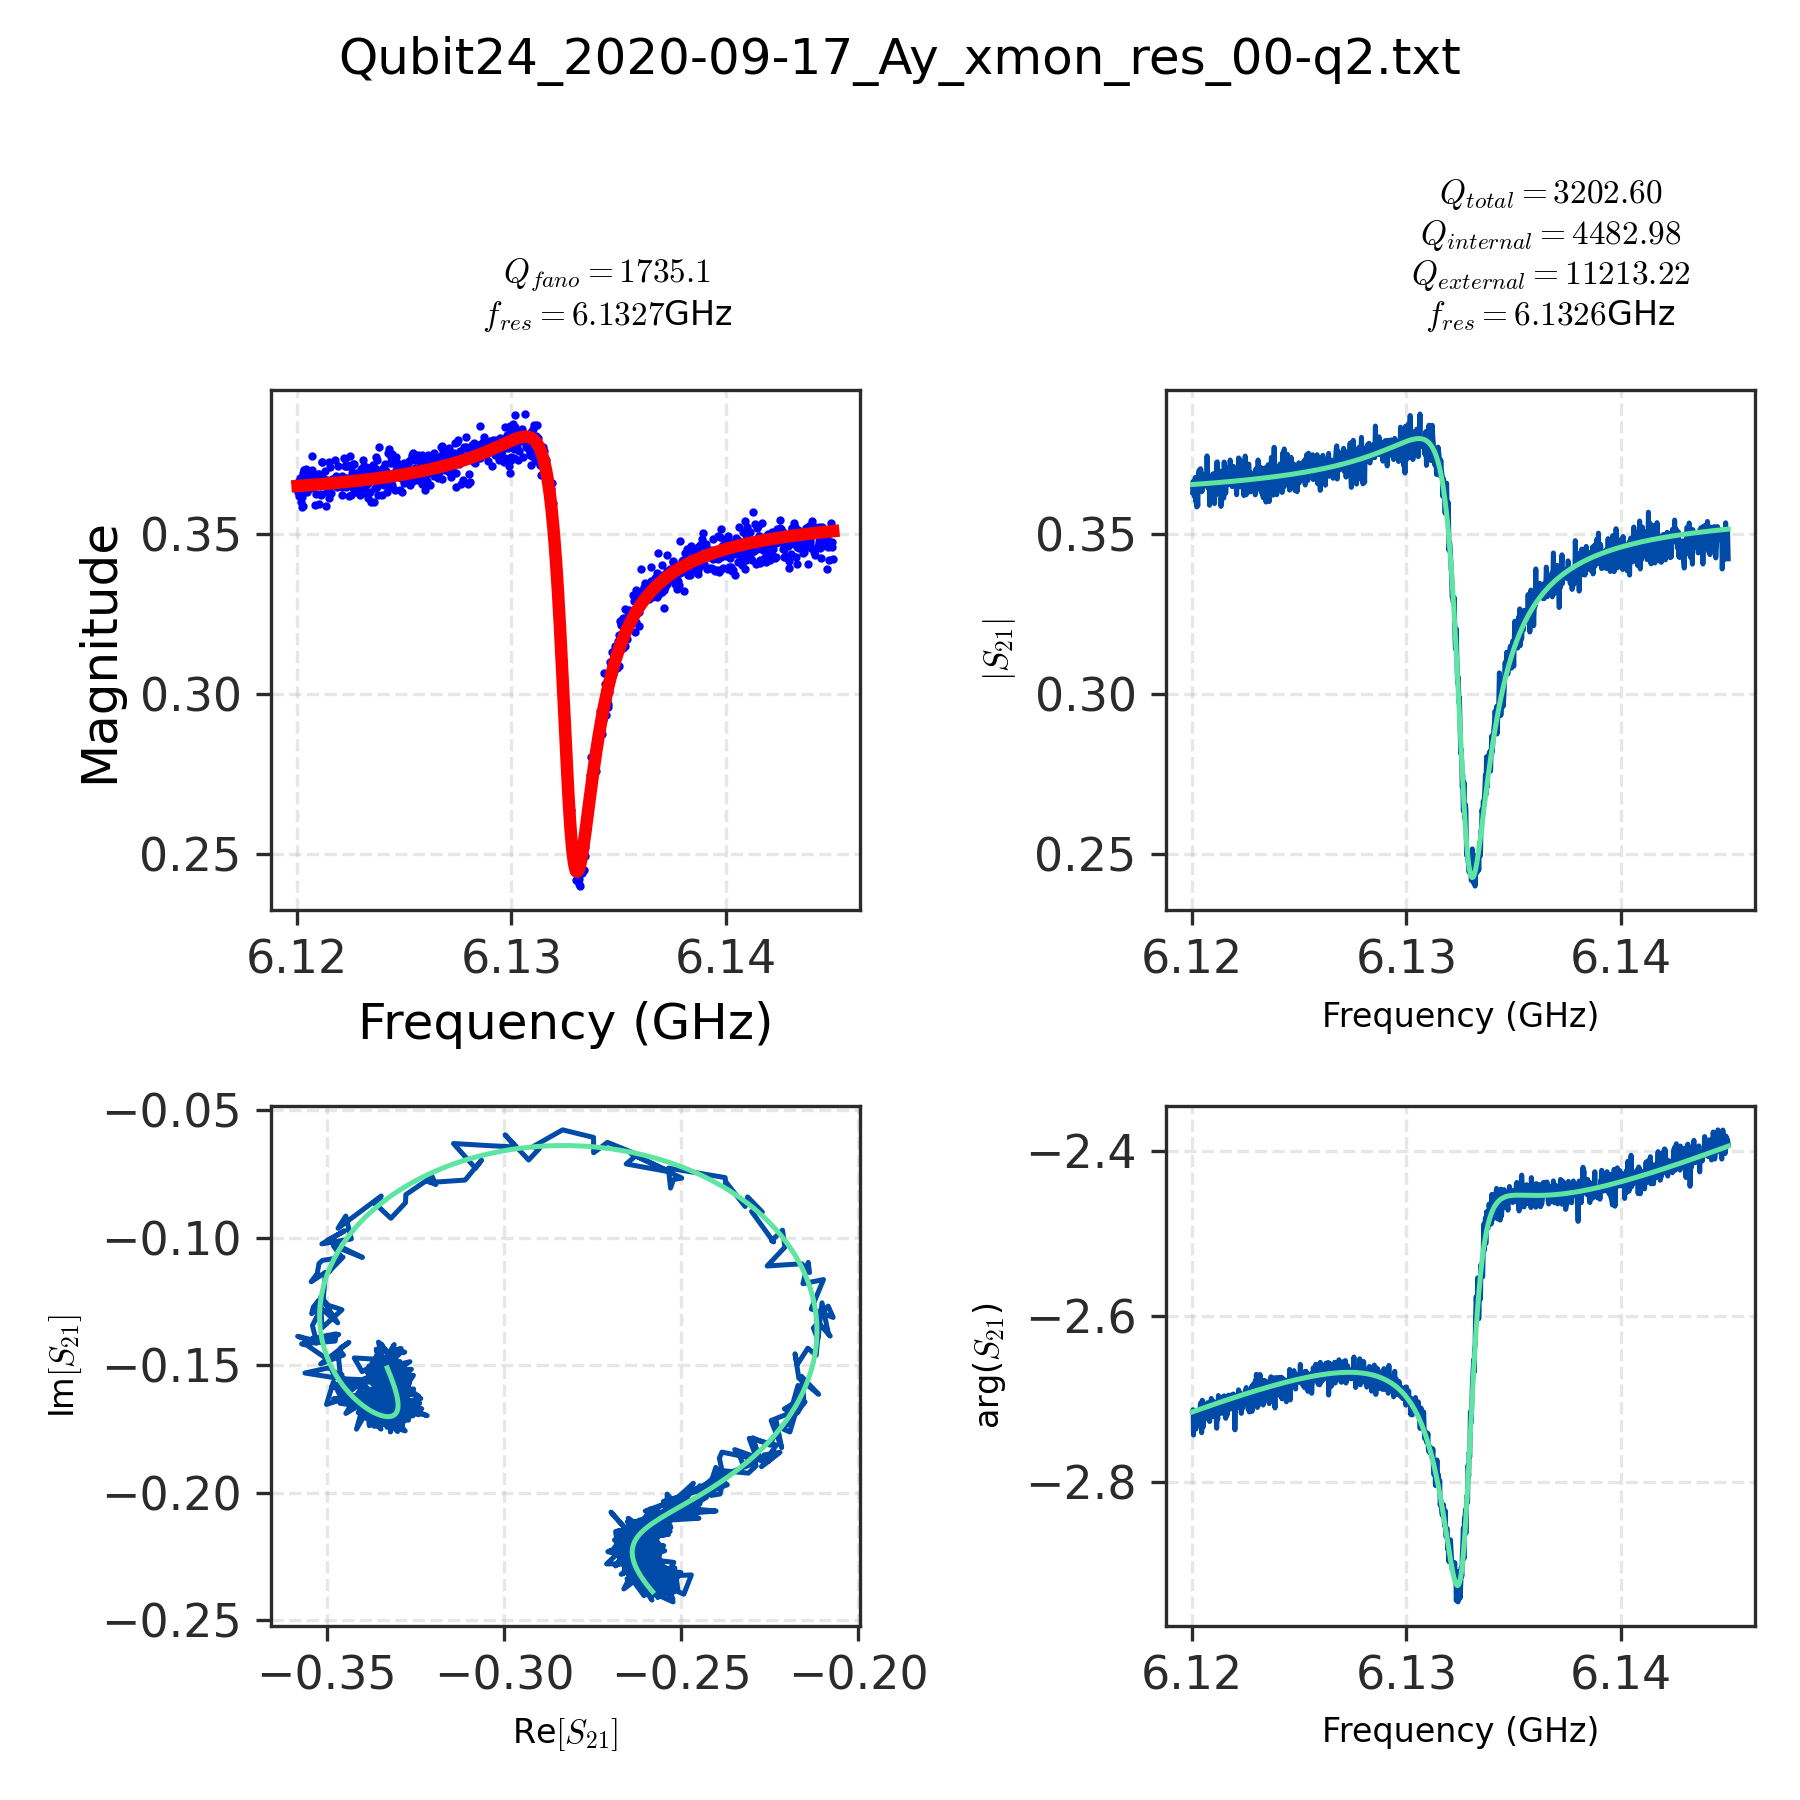

In [105]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_Ay_xmon_res_00-q2.txt'
df = pd.read_csv(FILENAME, sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.1222*GHz,
        1,
        0.4,
        0,
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>


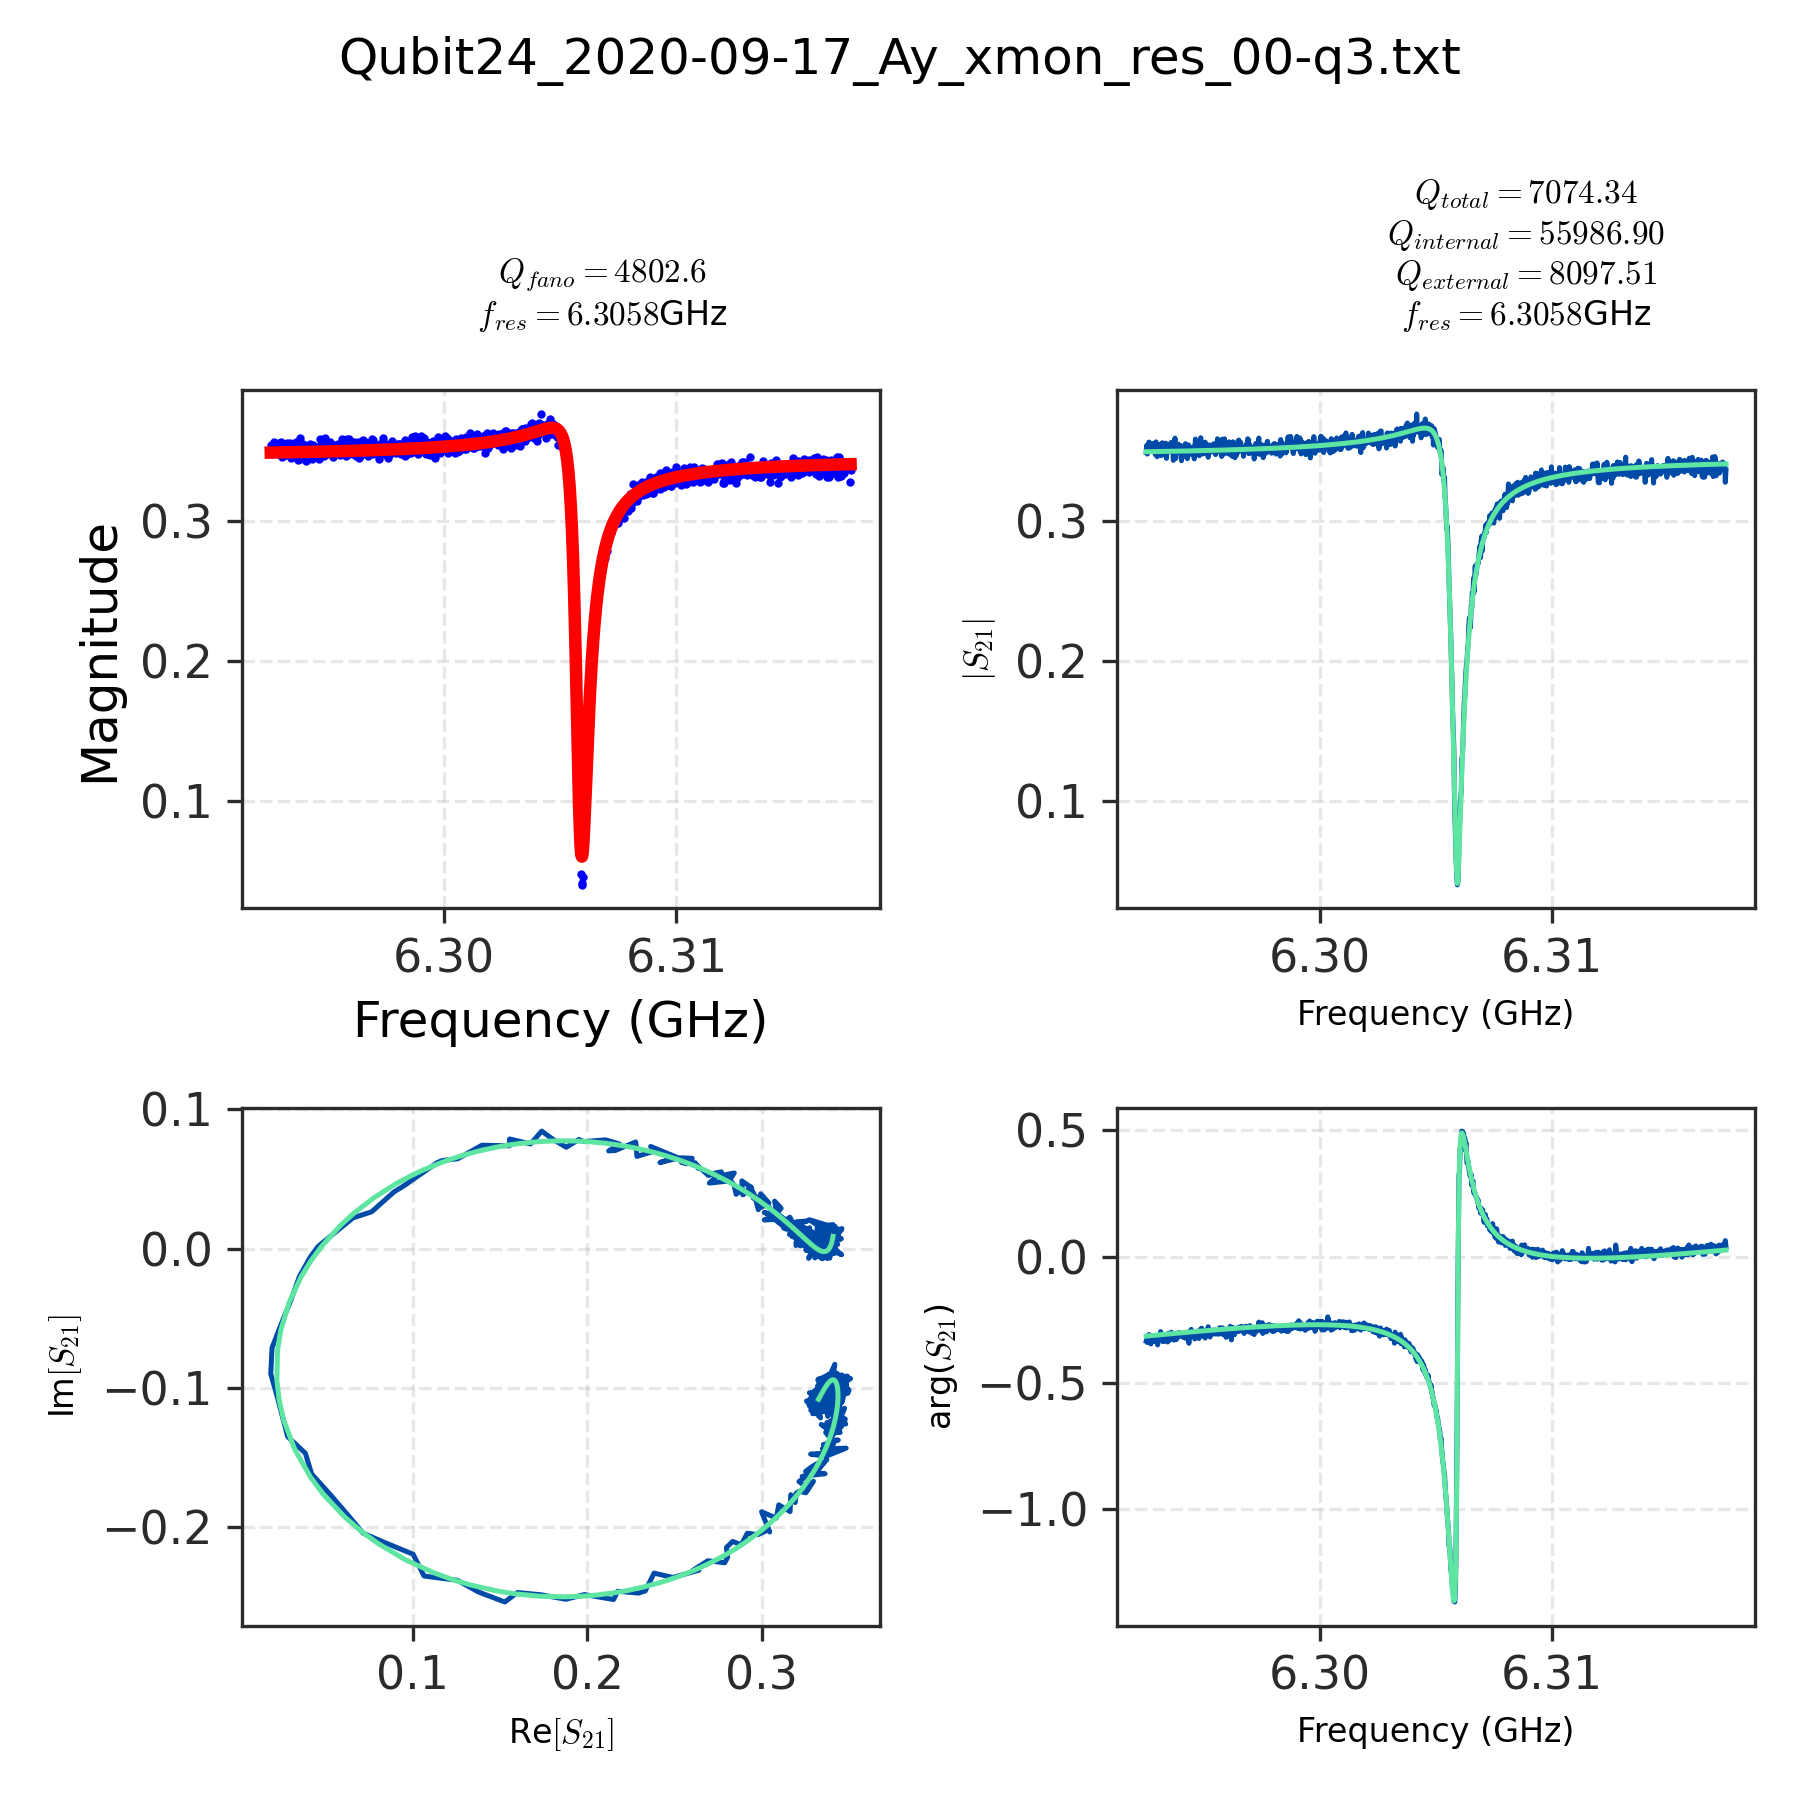

In [104]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_Ay_xmon_res_00-q3.txt'
df = pd.read_csv(FILENAME, sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.3058*GHz,
        1,
        0.4,
        0,
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>


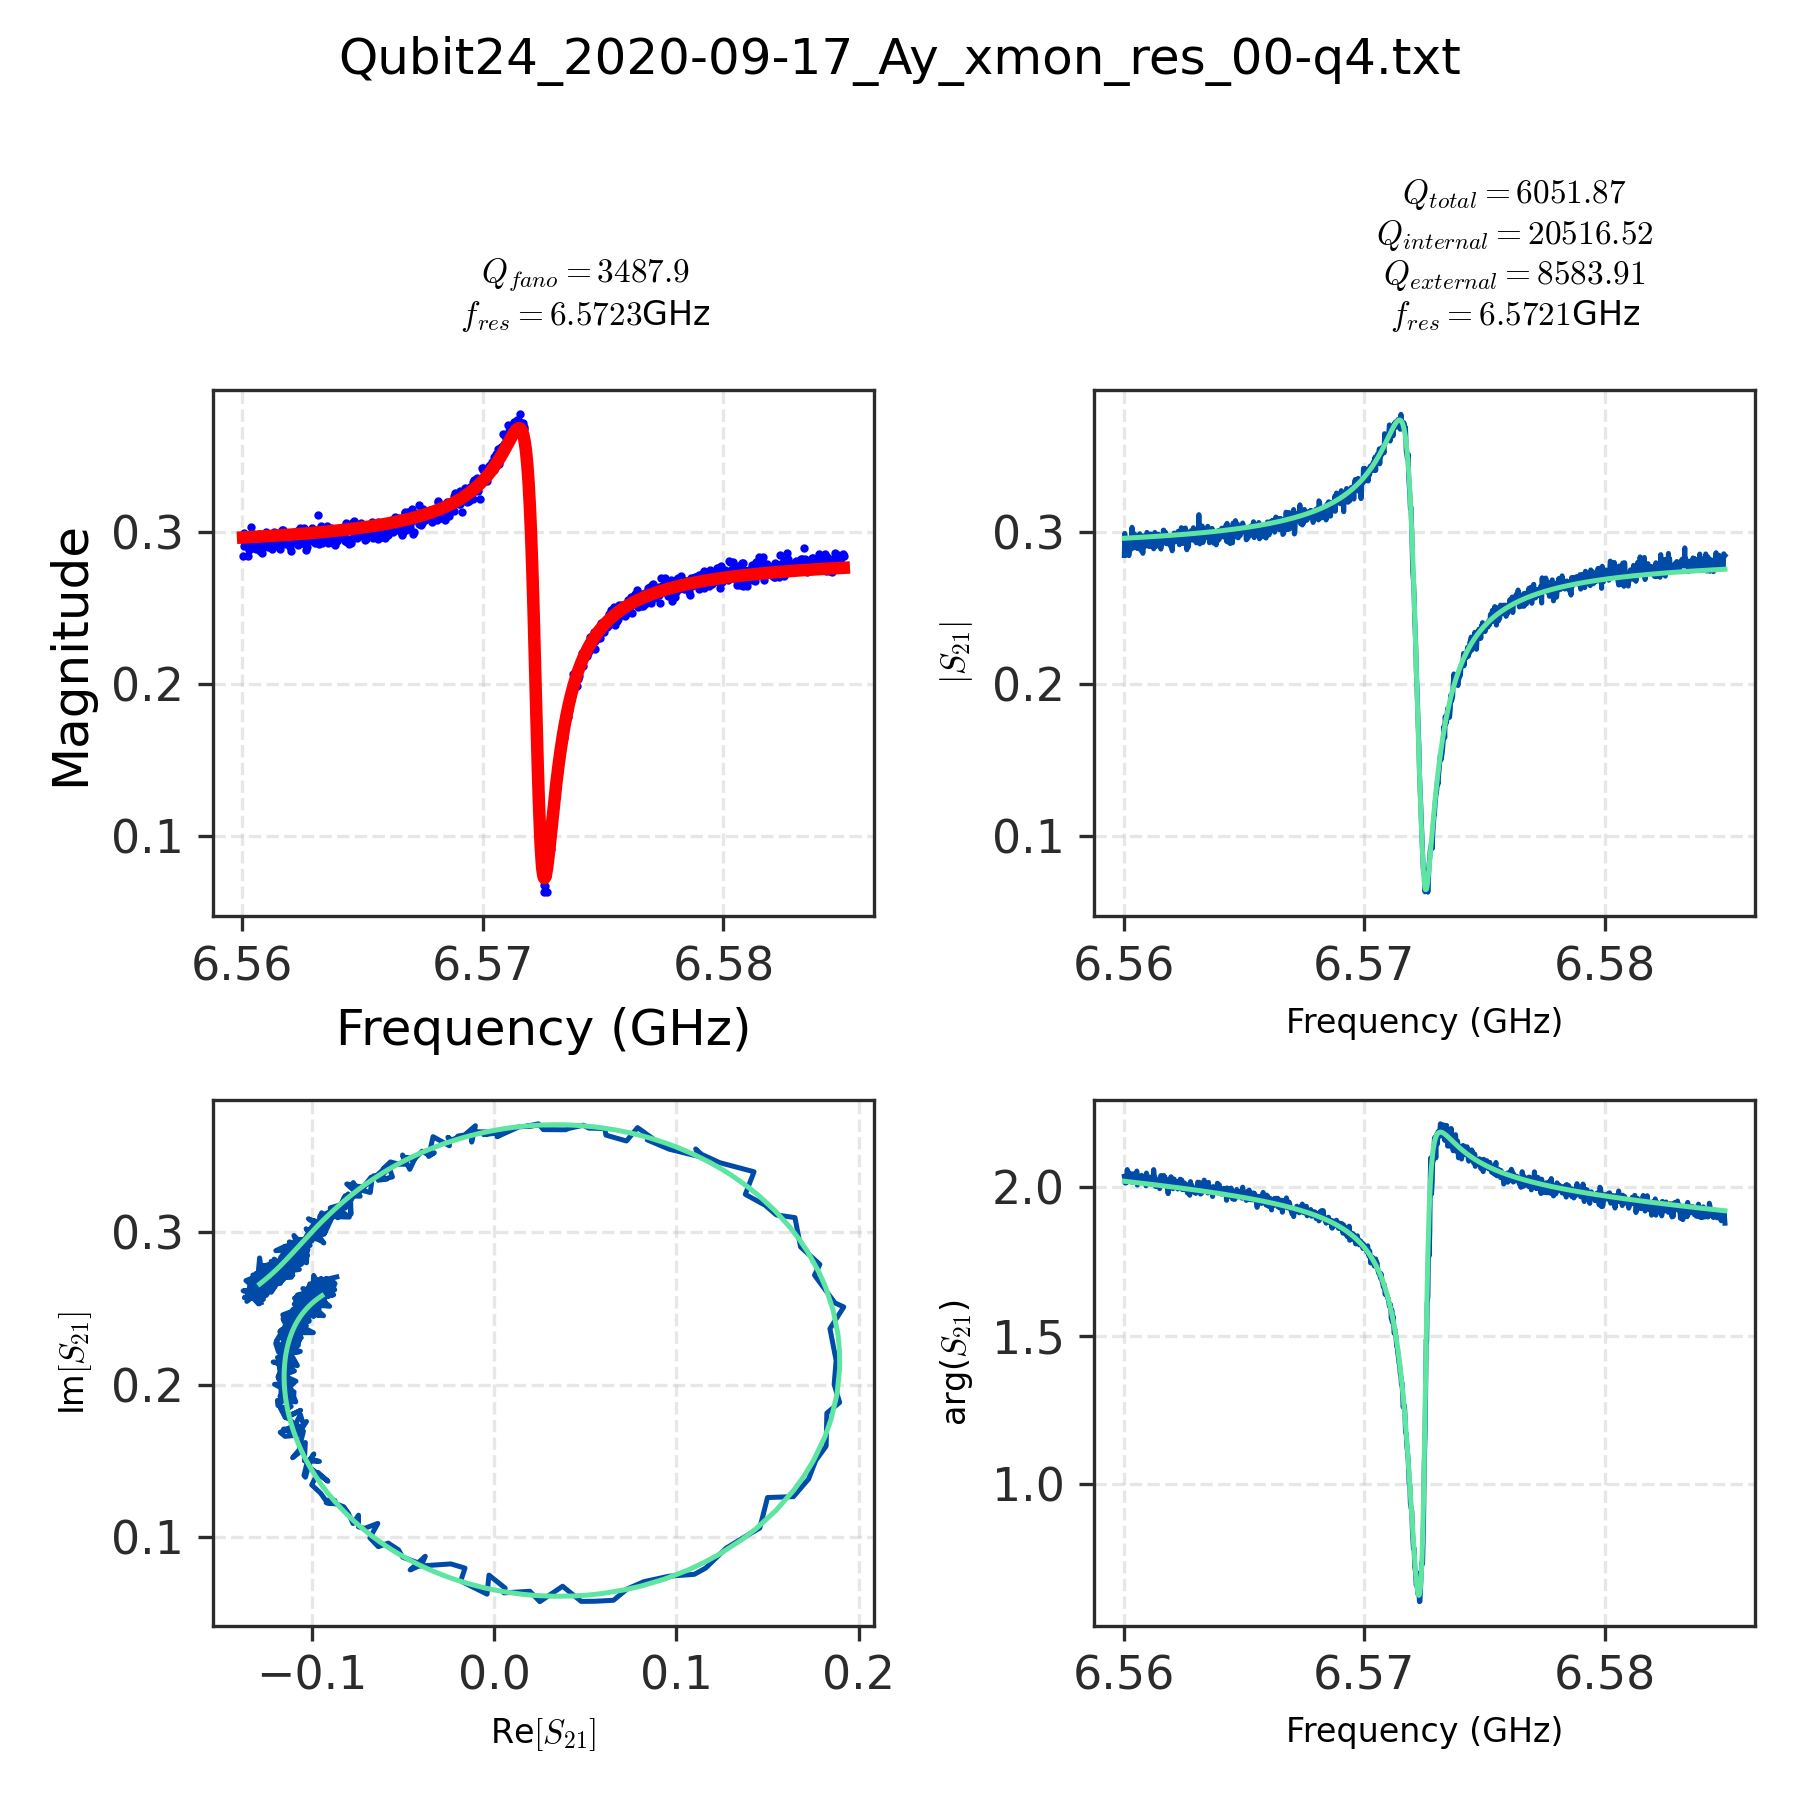

In [106]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_Ay_xmon_res_00-q4.txt'
df = pd.read_csv(FILENAME, sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.5721*GHz,
        1,
        0.4,
        0,
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

Failed circle fit


/Users/CCCP/.config/python_vi/qubit/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


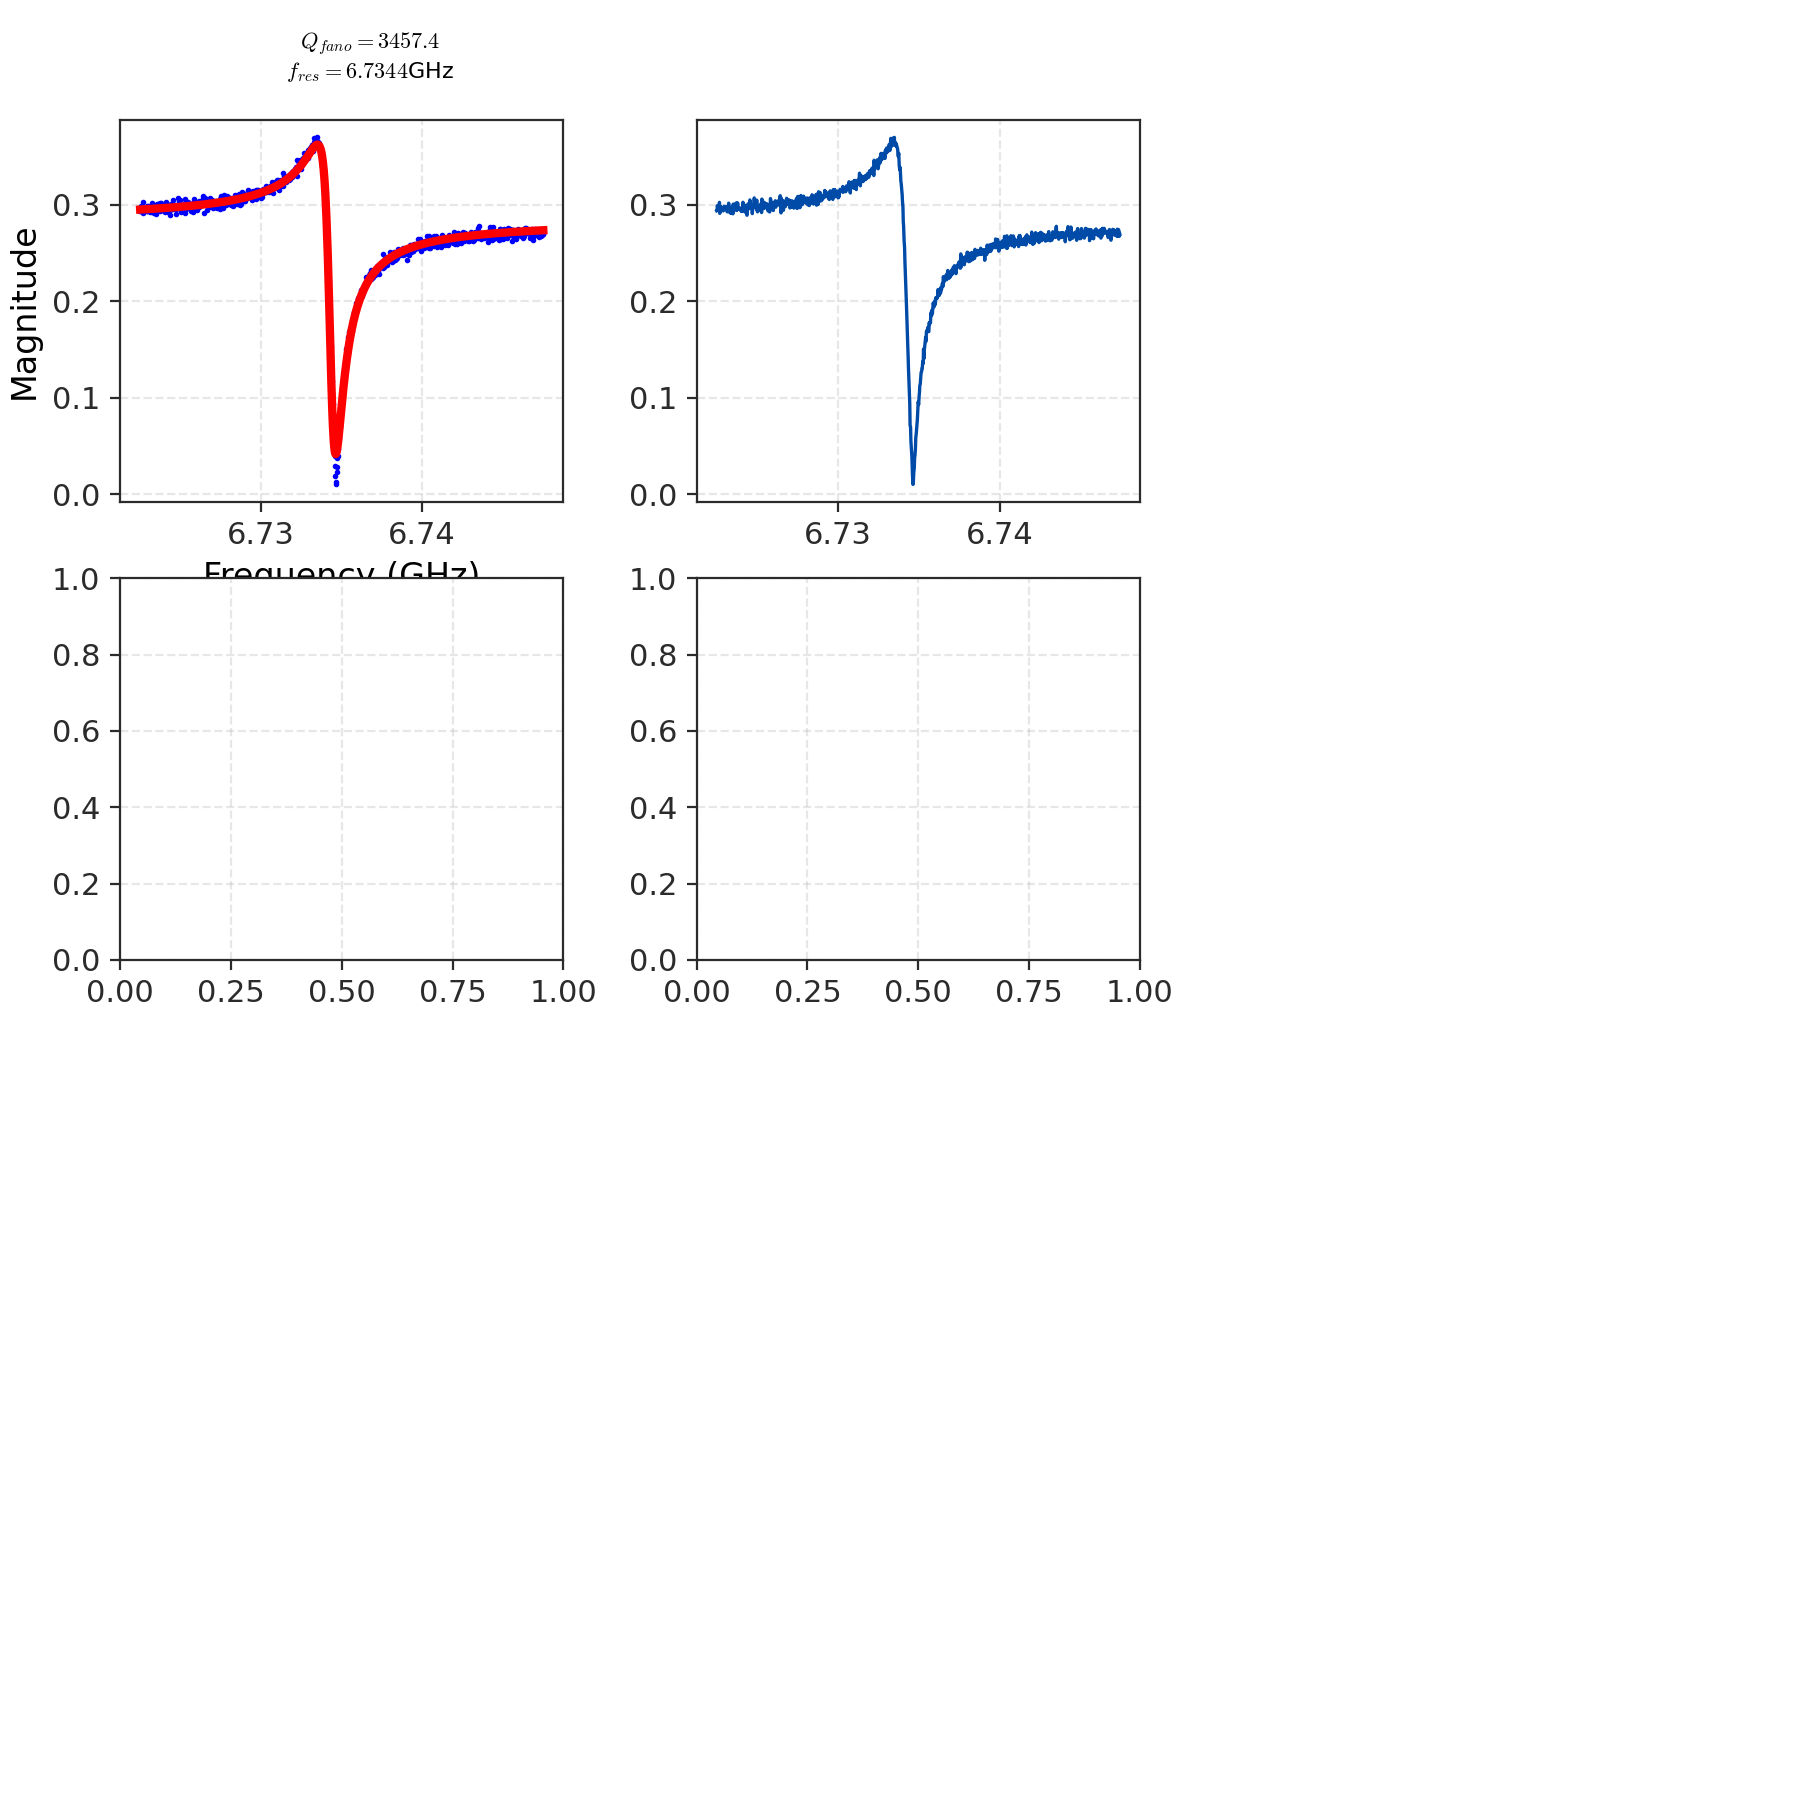

AttributeError: 'notch_port' object has no attribute 'z_data_sim'

In [117]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_Ay_xmon_res_00-unloaded.txt'
df = pd.read_csv(FILENAME, sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.77*GHz,
        1,
        0.4,
        0,
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

# 2021-03-16_transmon-with-filter

In [4]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2021-03-16_transmon-with-filter/2021-03-16_transmon-with-filter_01_resonators-q1.txt'
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        5.988*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


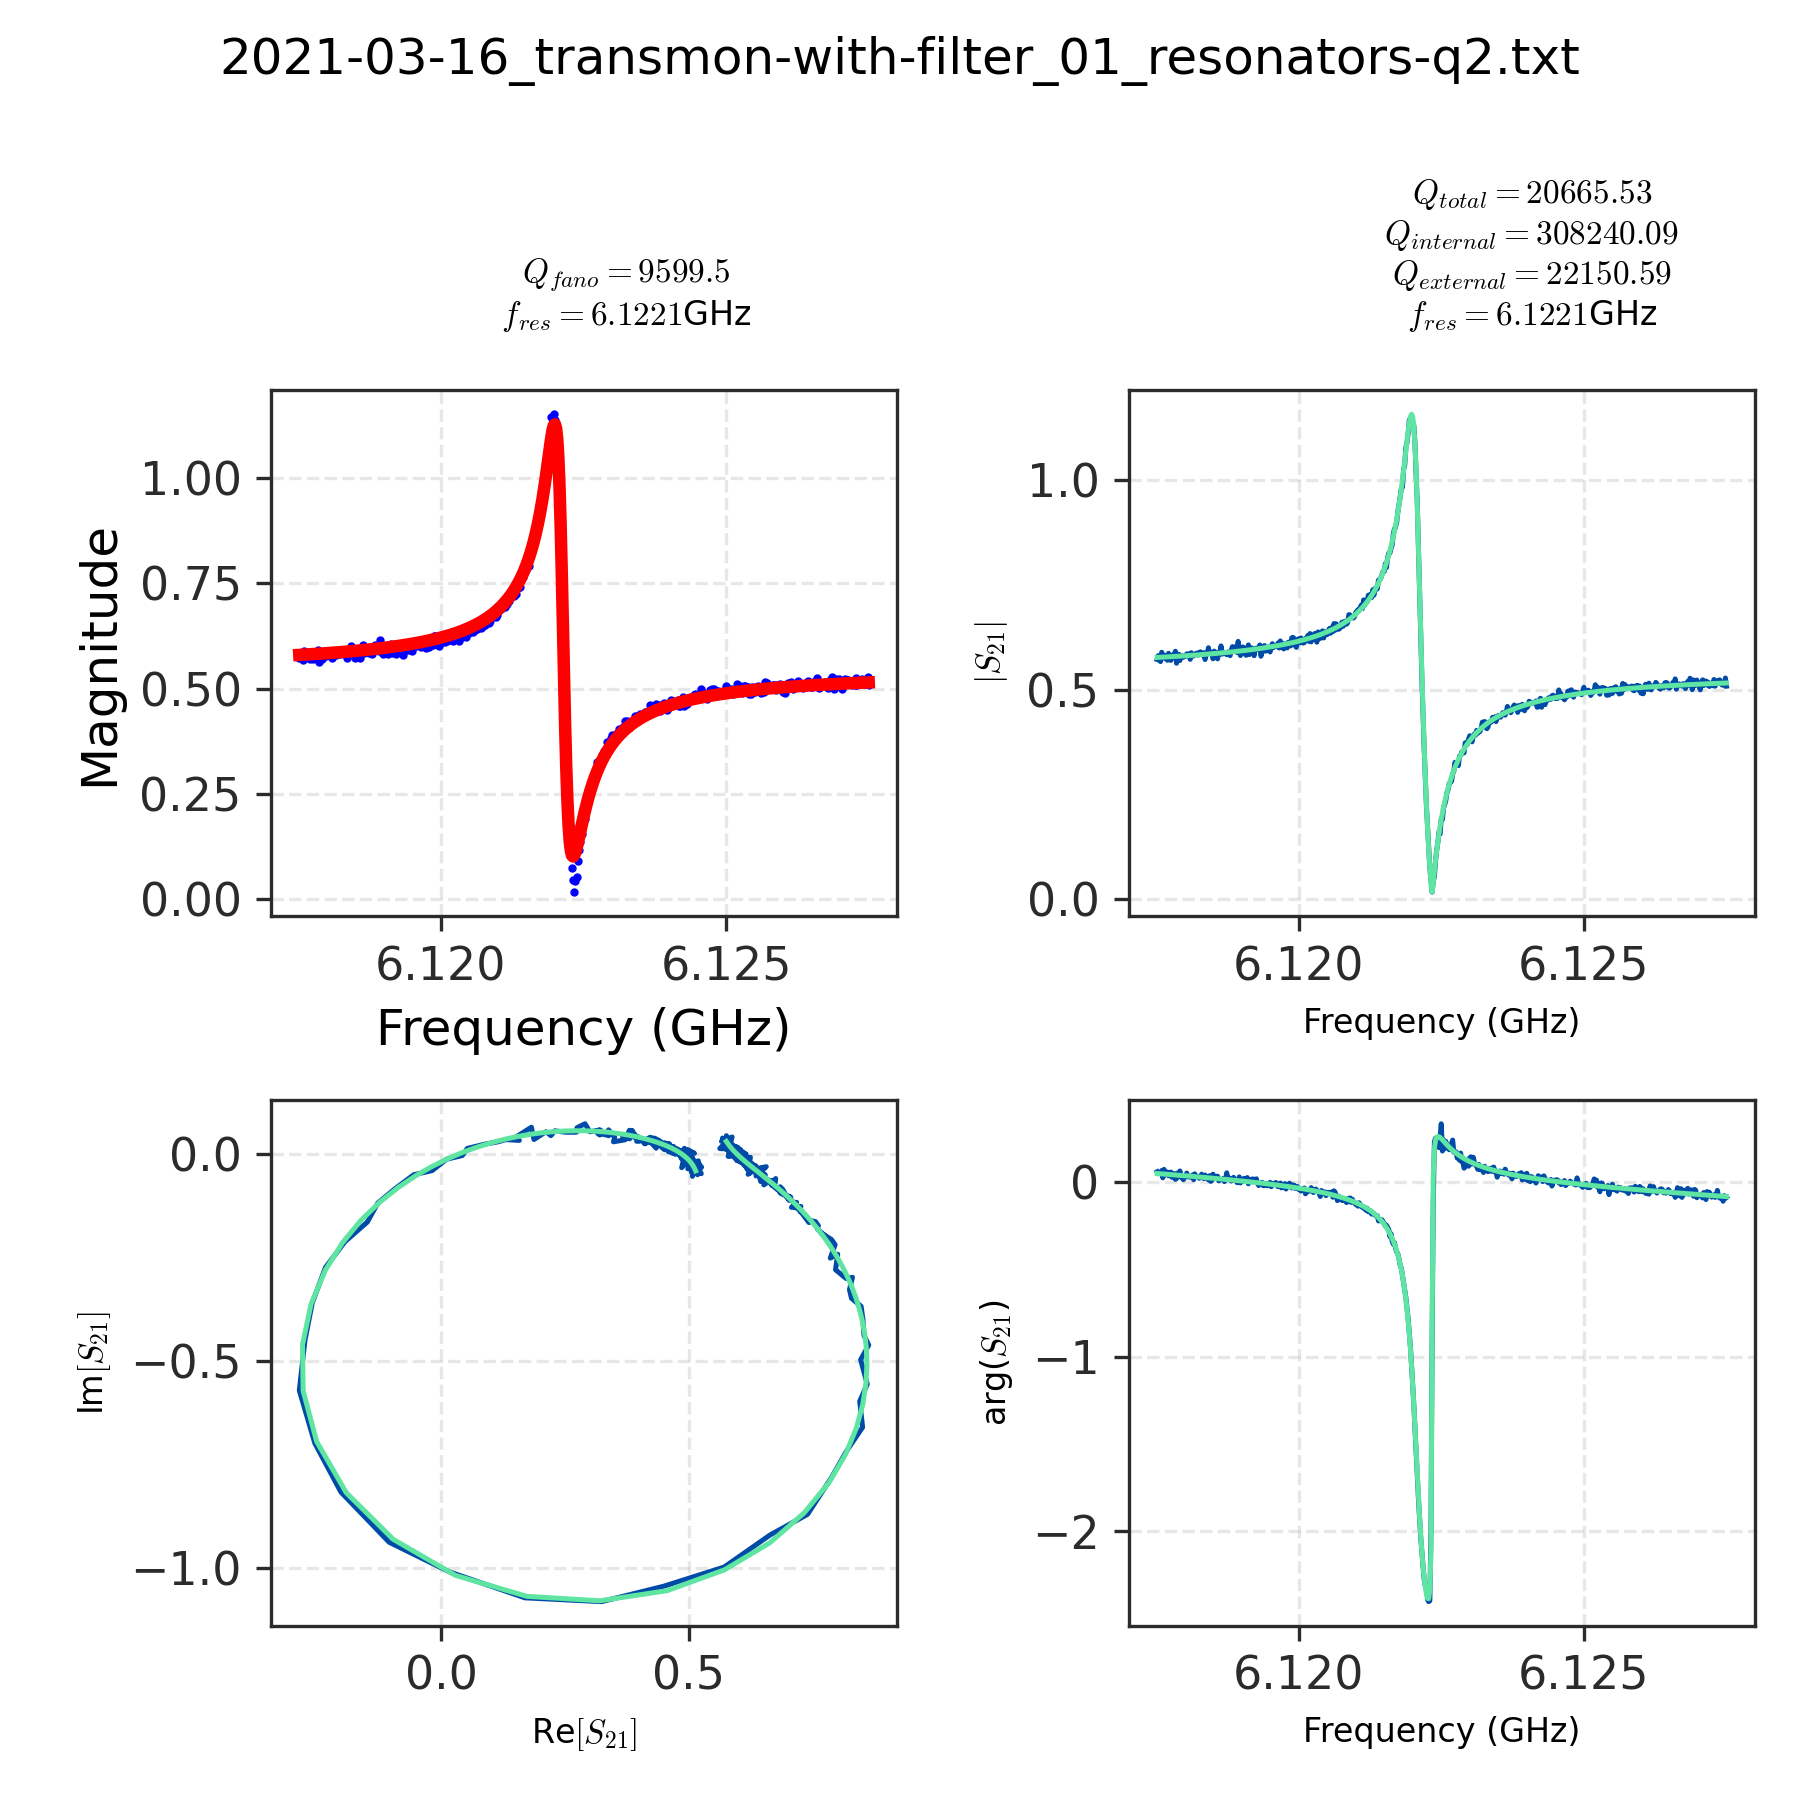

In [120]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2021-03-16_transmon-with-filter/2021-03-16_transmon-with-filter_01_resonators-q2.txt'
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.1222*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>


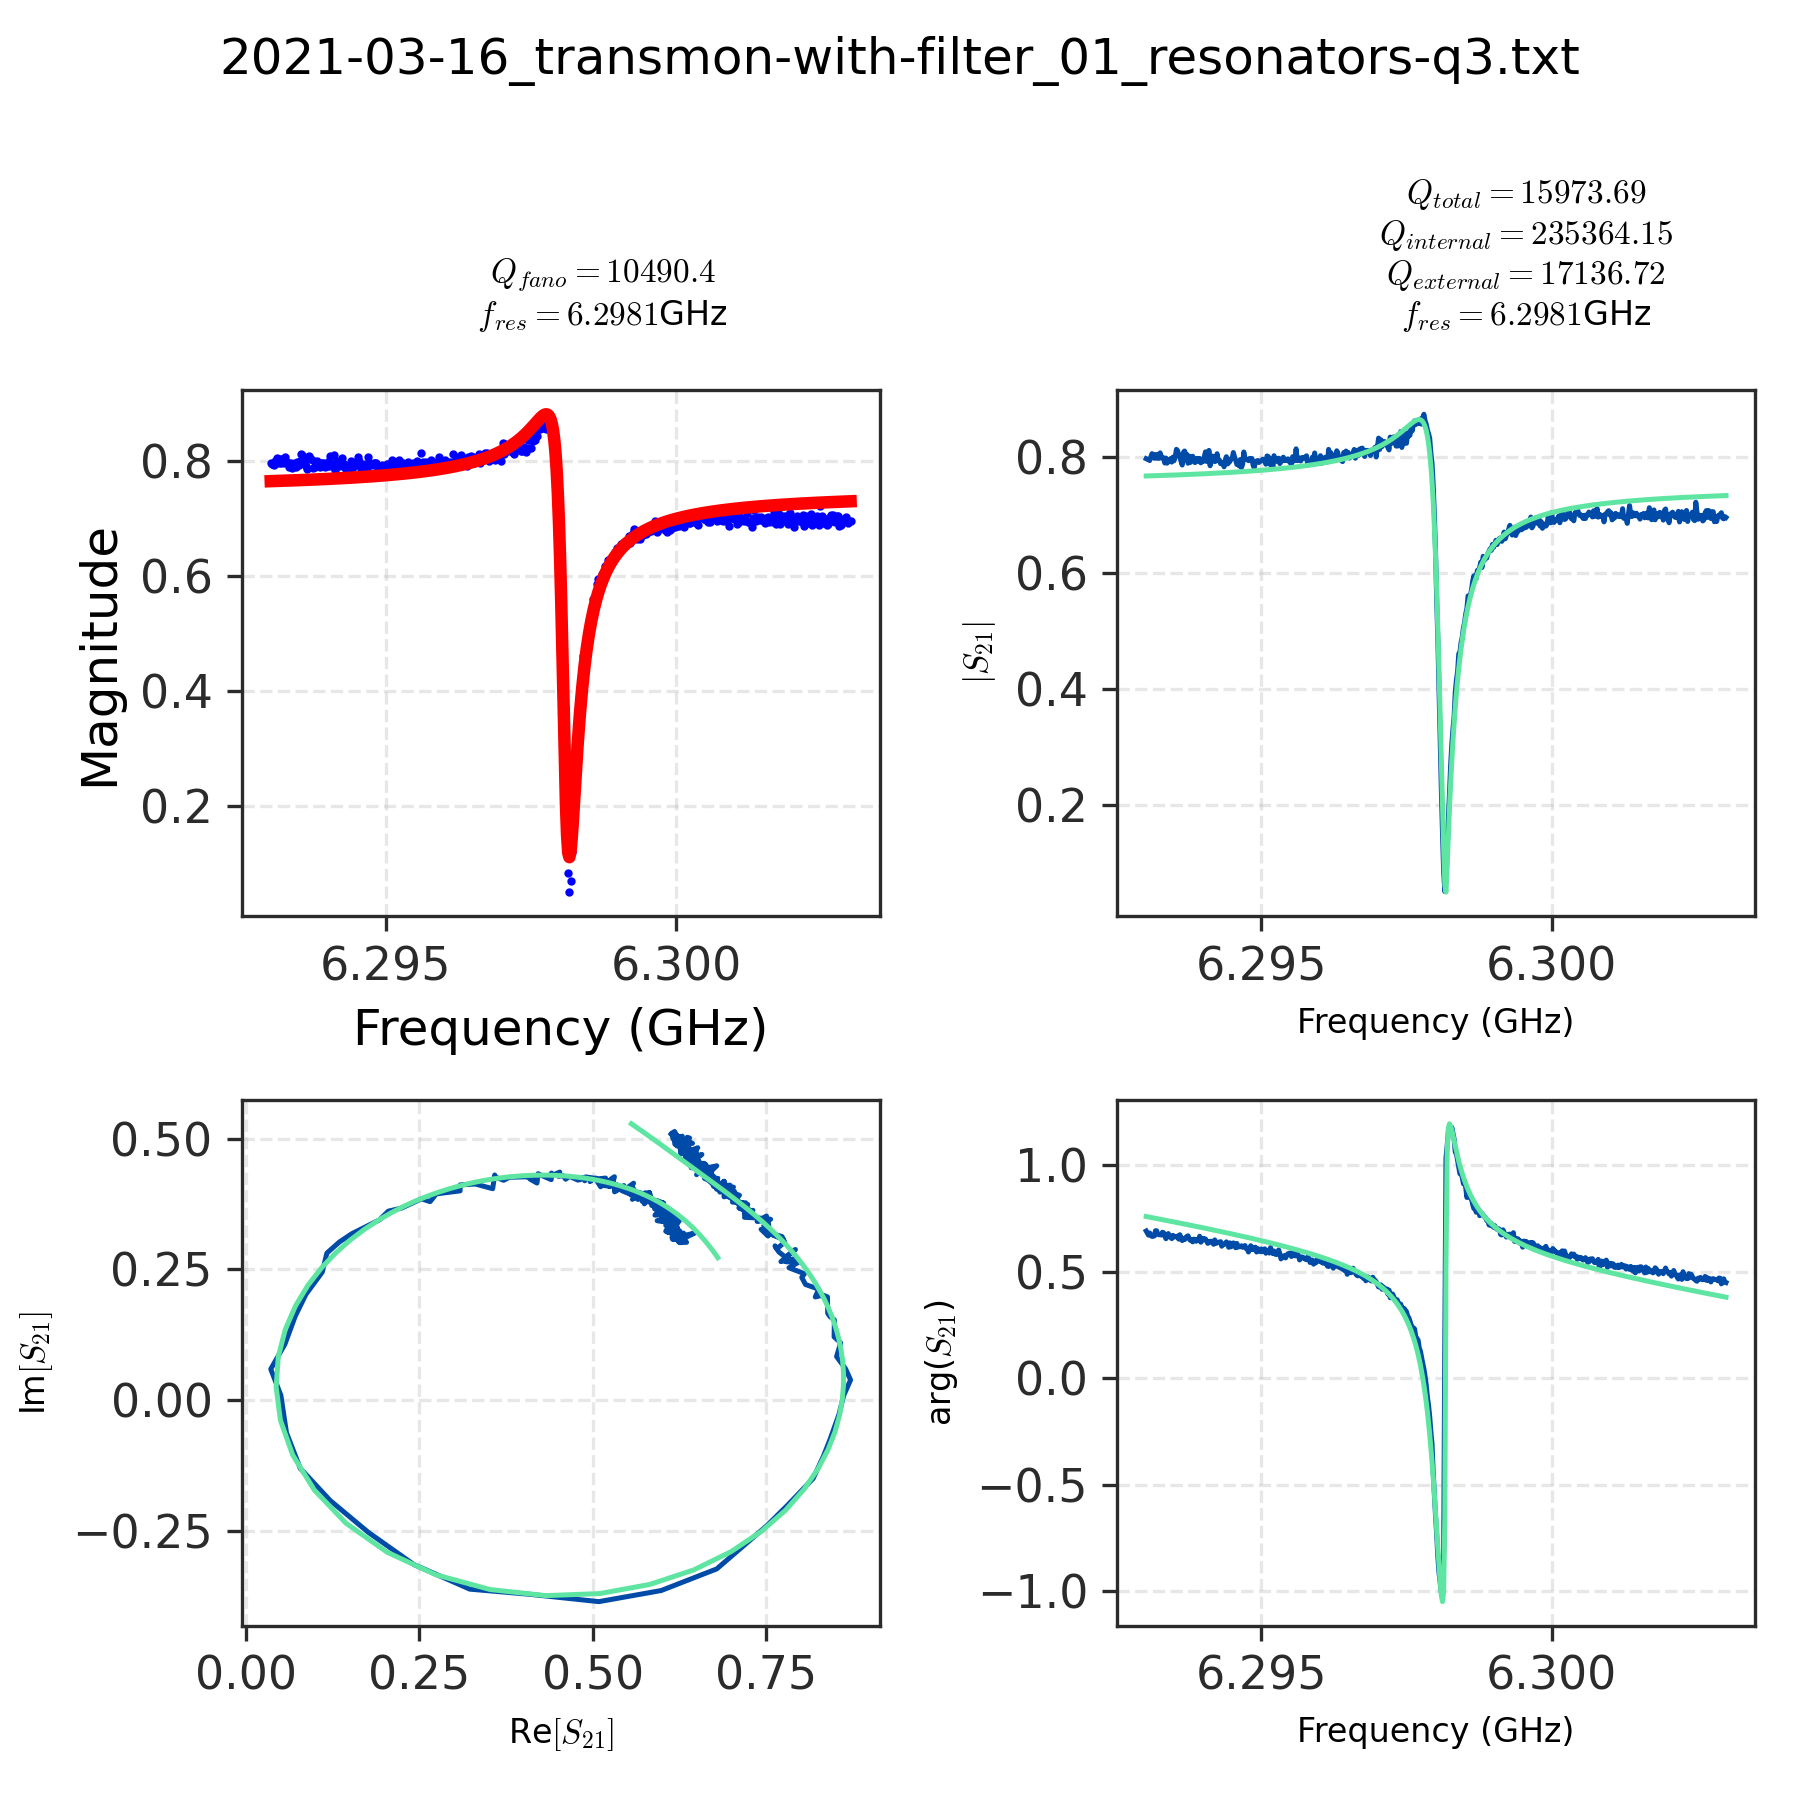

In [121]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2021-03-16_transmon-with-filter/2021-03-16_transmon-with-filter_01_resonators-q3.txt'
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.2981*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>


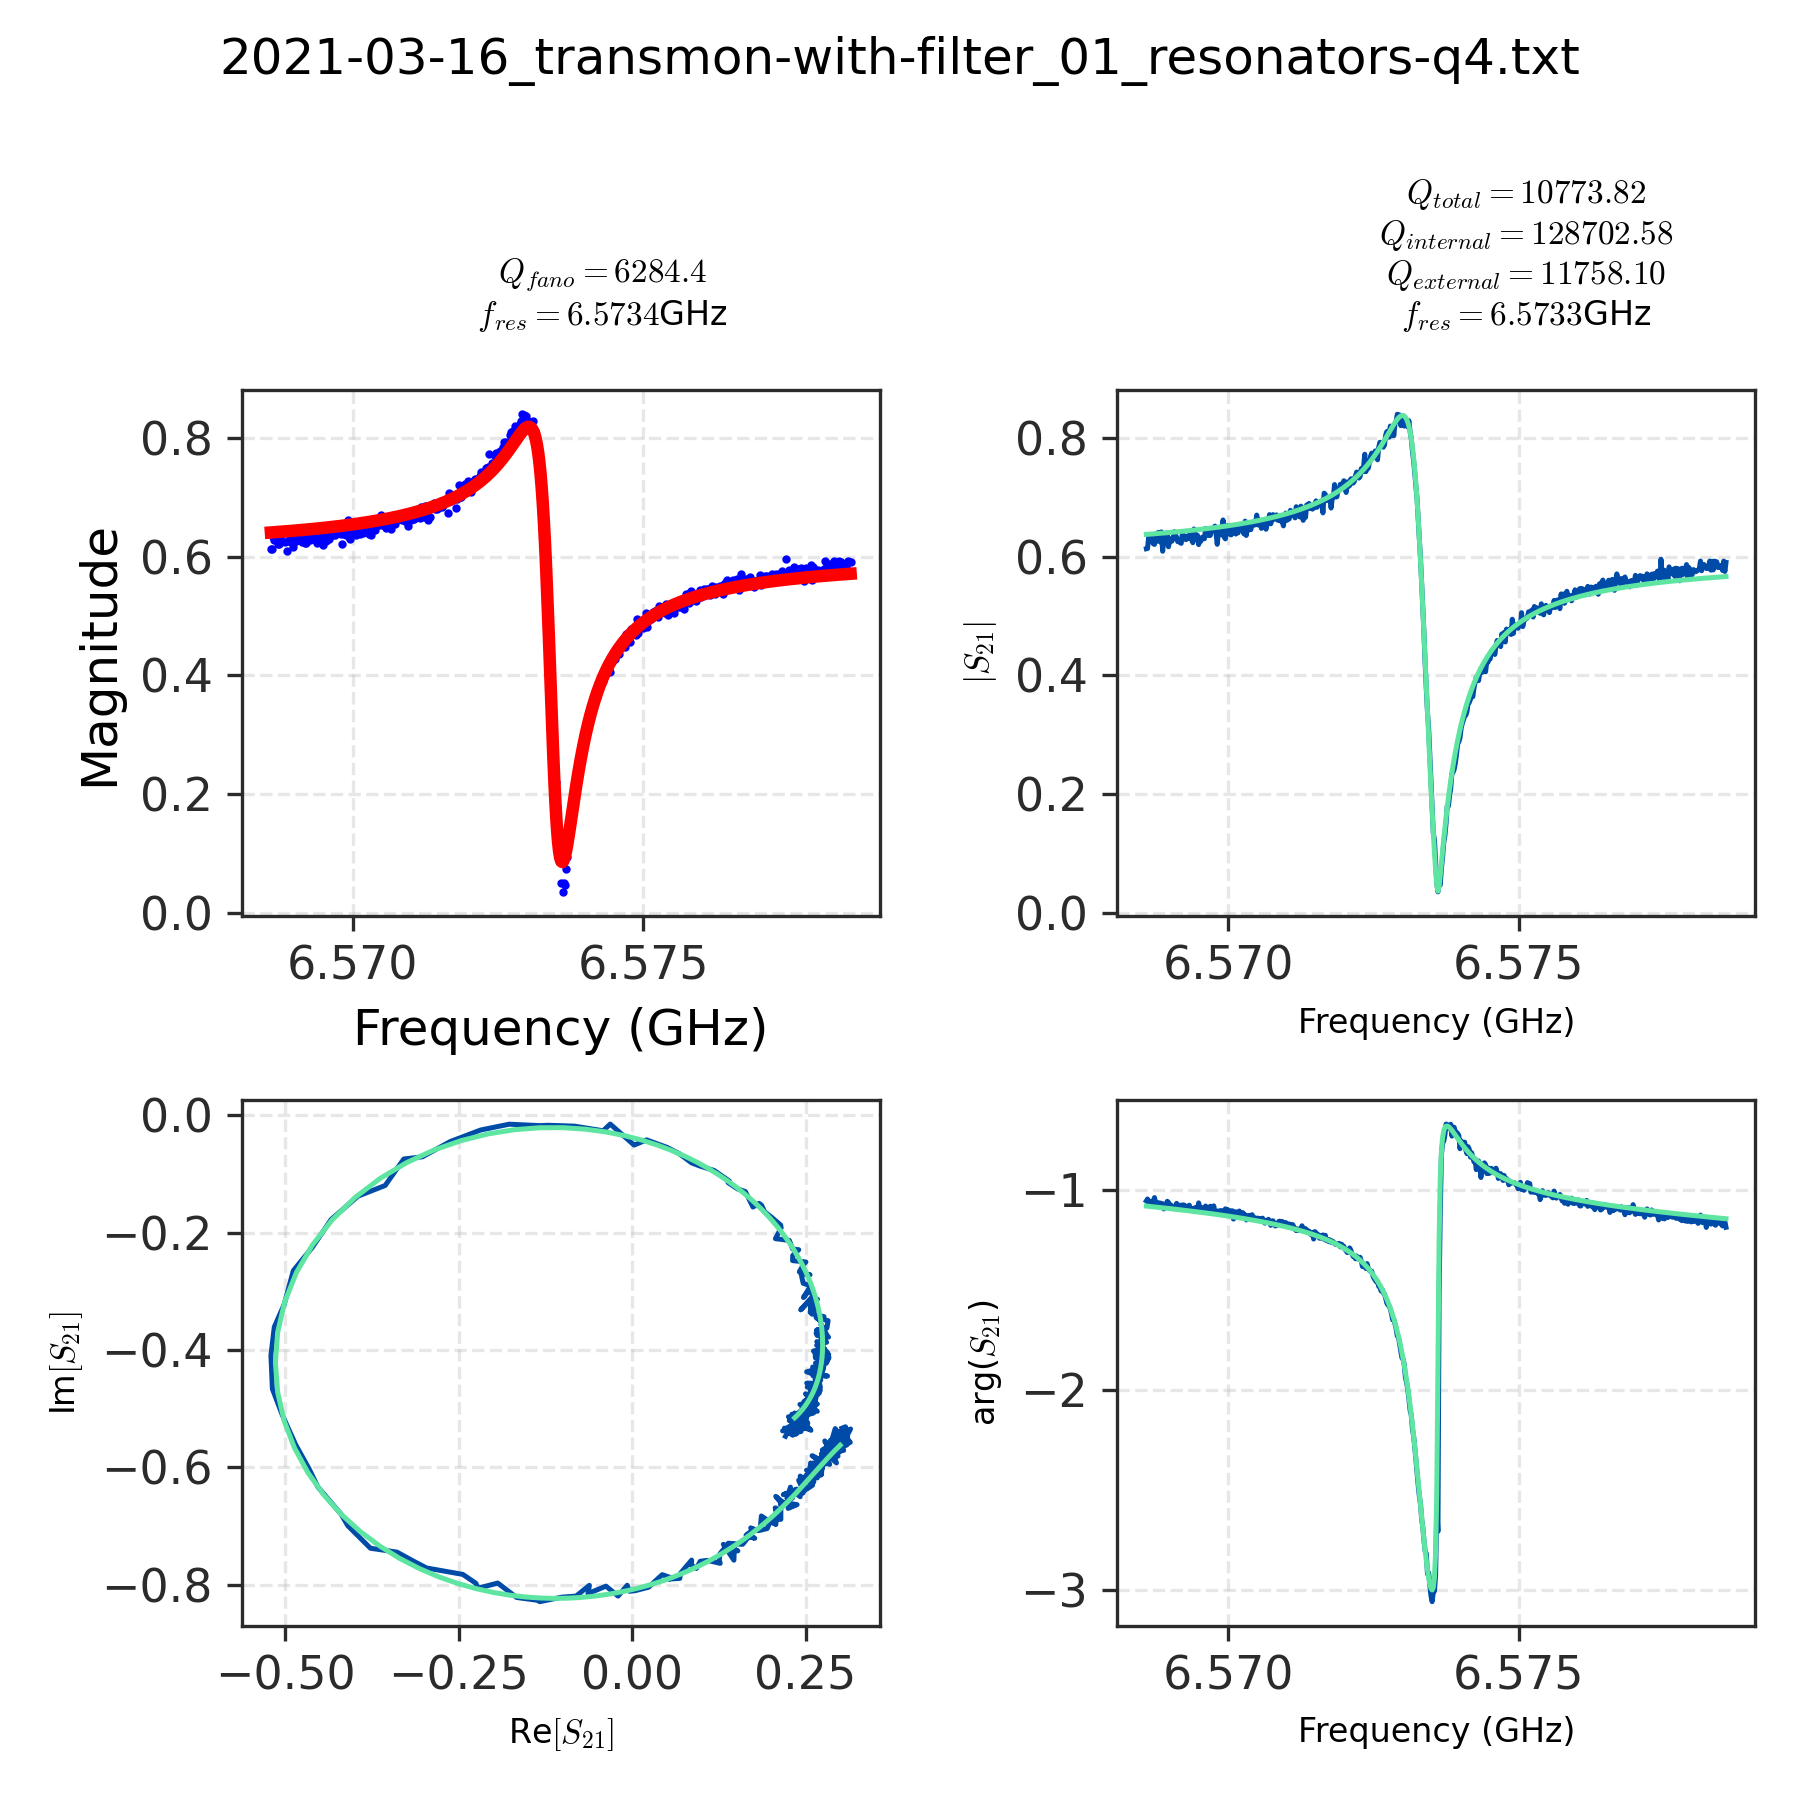

In [124]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2021-03-16_transmon-with-filter/2021-03-16_transmon-with-filter_01_resonators-q4.txt'
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.5733*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))

<IPython.core.display.Javascript object>


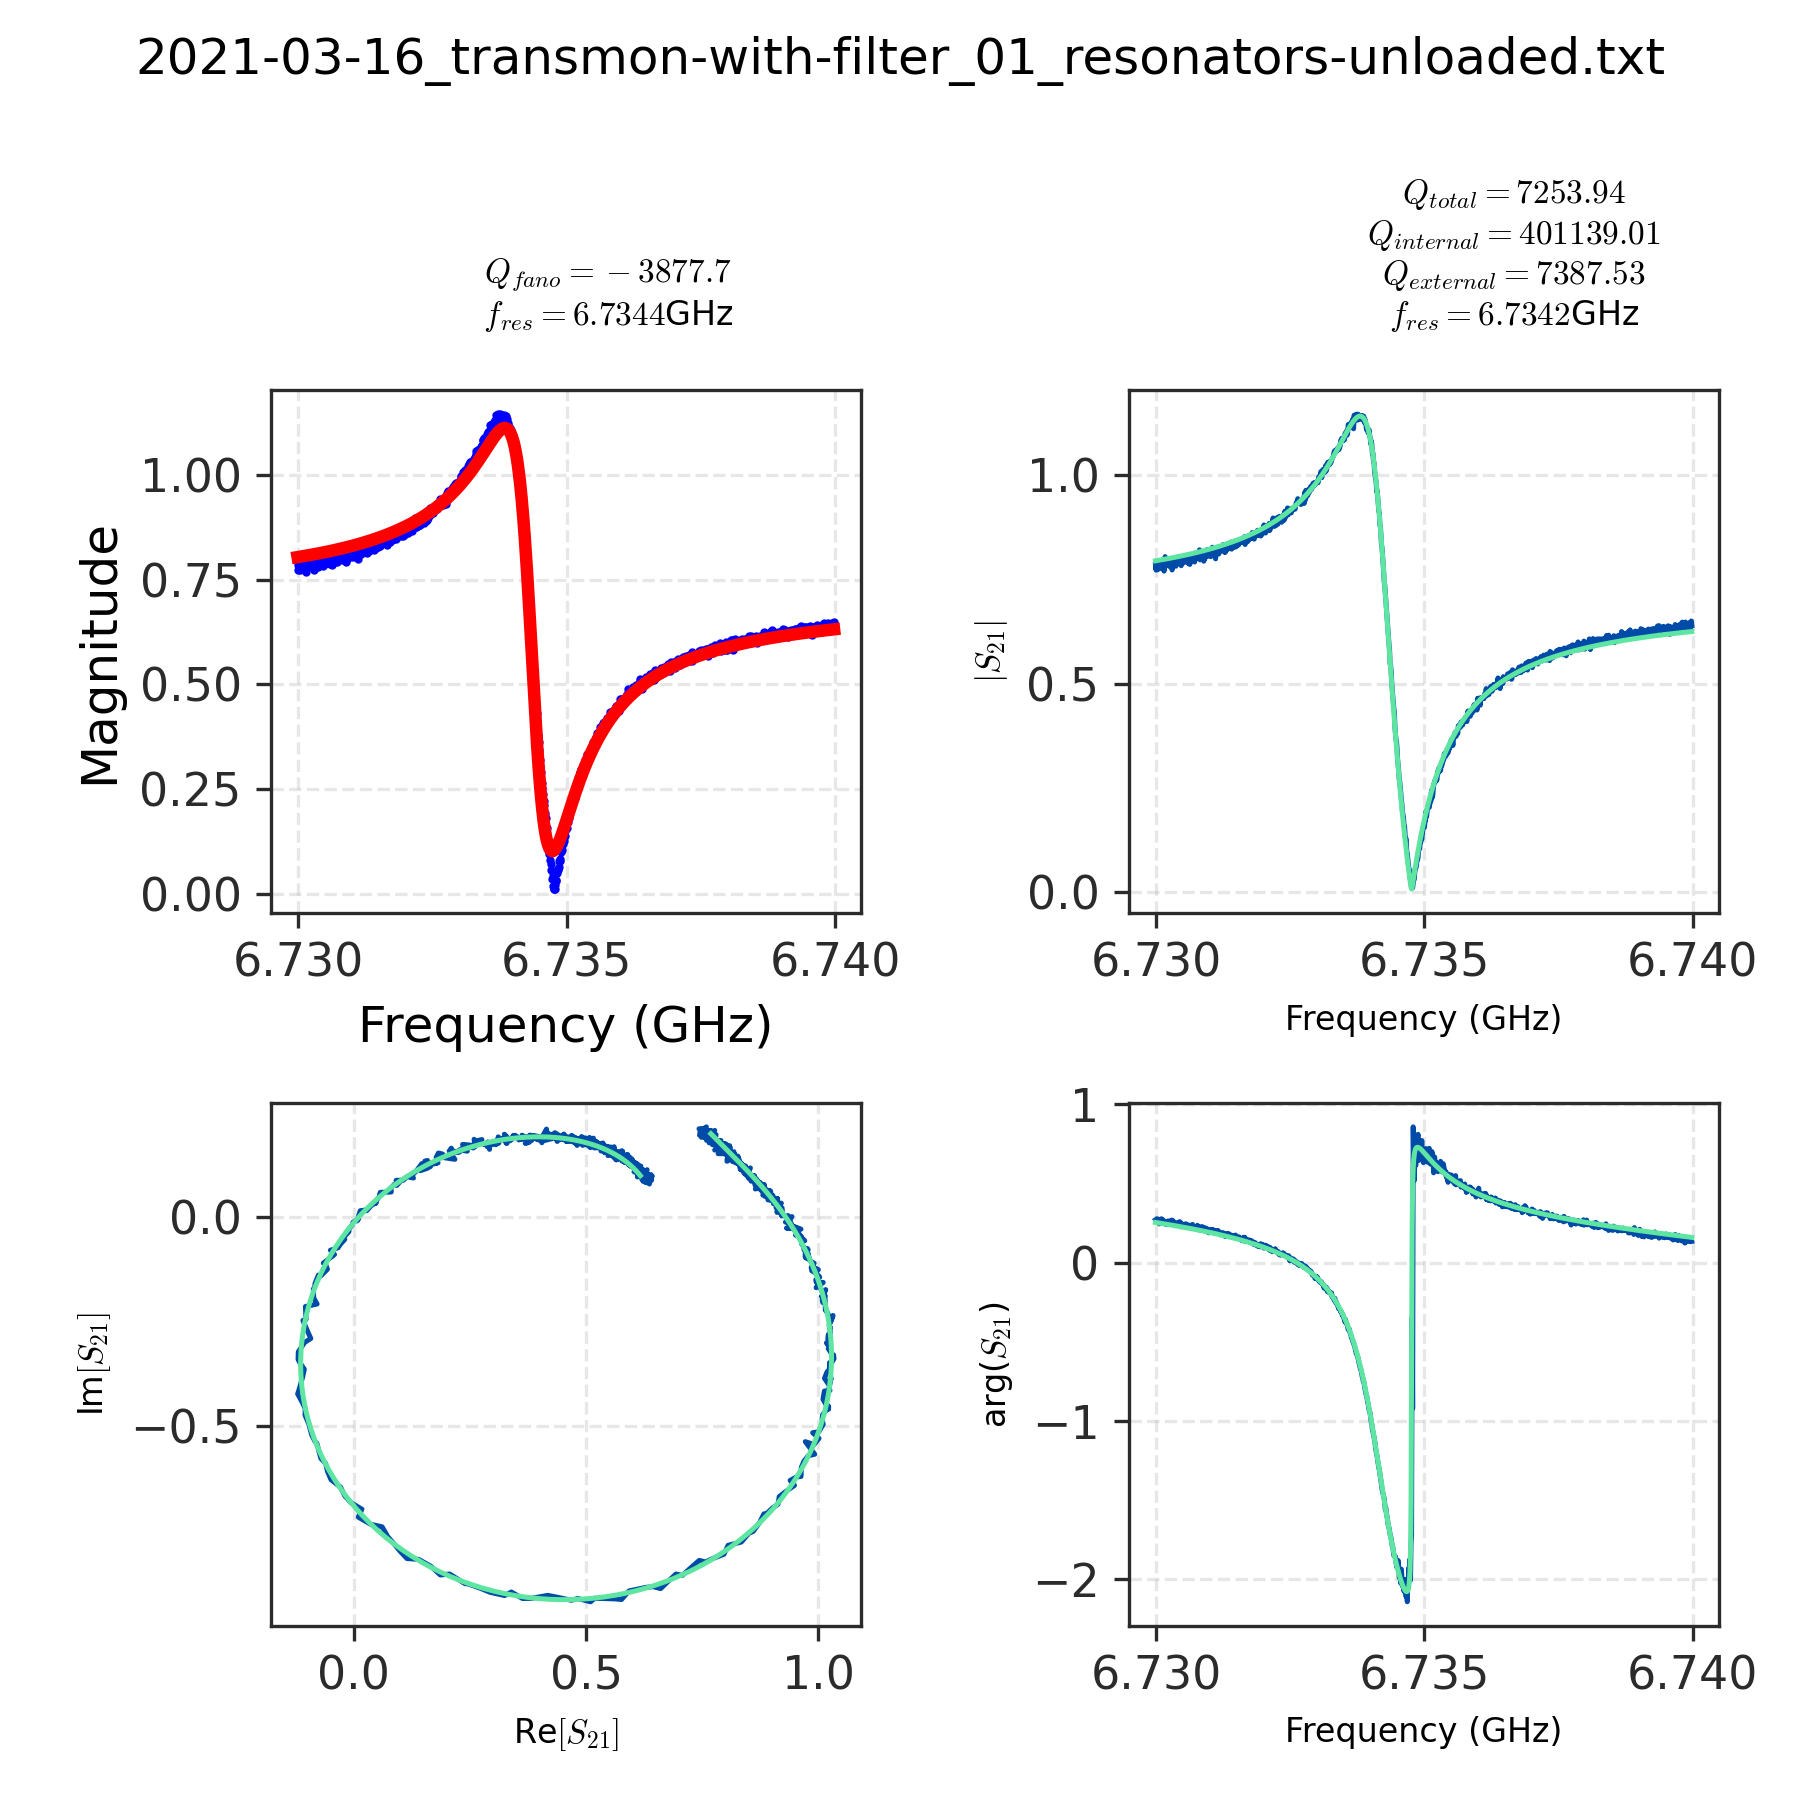

In [123]:
FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/qubit_simulations/data/2021-03-16_transmon-with-filter/2021-03-16_transmon-with-filter_01_resonators-unloaded.txt'
NAME = "Unloaded - With filter"

df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]


resonator_evaluator(
    df,
    [
        6.7342*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png"))